# Anime Recommendations
This project is based on [this dataset](https://www.kaggle.com/CooperUnion/anime-recommendations-database) and it's goal is to make anime recommendations better.

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot, Embedding, Concatenate, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelEncoder

ANIME_PATH = os.path.join("..", "data")

def load_anime_data(filename, anime_path=ANIME_PATH):
    csv_path = os.path.join(anime_path, filename)
    return pd.read_csv(csv_path)

/Users/zengraf/.asdf/installs/python/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
anime = load_anime_data("anime.csv")
rating = load_anime_data("rating.csv")[:300000]

## Data description
### Anime.csv
- anime_id - myanimelist.net's unique id identifying an anime.
- name - full name of anime.
- genre - comma separated list of genres for this anime.
- type - movie, TV, OVA, etc.
- episodes - how many episodes in this show. (1 if movie).
- rating - average rating out of 10 for this anime.
- members - number of community members that are in this anime's
- "group".

### Rating.csv
- user_id - non identifiable randomly generated user id.
- anime_id - the anime that this user has rated.
- rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

In [3]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [5]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [6]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   user_id   300000 non-null  int64
 1   anime_id  300000 non-null  int64
 2   rating    300000 non-null  int64
dtypes: int64(3)
memory usage: 6.9 MB


In [7]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [8]:
rating.describe()

,user_id,anime_id,rating
count,300000.00000,300000.000000,300000.000000
mean,1539.58289,11248.155323,6.053943
std,887.86059,9209.716292,3.829522
min,1.00000,1.000000,-1.000000
25%,776.00000,2889.000000,5.000000
50%,1505.00000,9989.000000,7.000000
75%,2308.00000,17729.000000,9.000000
max,3093.00000,34325.000000,10.000000


When `rating` is equal to -1, that means that the user watched the series, but didn't rate it.

In [9]:
(rating["rating"] == -1).sum()

61408

In [10]:
rating.groupby("user_id")[["anime_id"]].count().describe()

,anime_id
count,3093.000000
mean,96.993210
std,128.309839
min,1.000000
25%,18.000000
50%,56.000000
75%,124.000000
max,1584.000000


Missing data inside `episodes` column is indicated as `Unknown`, not `NaN`

Probably, this is true for ongoing anime

In [11]:
anime.loc[anime["episodes"] == "Unknown", "episodes"].count()

340

If `rating` is set to `NaN`, the anime hasn't probably been aired yet

In [12]:
anime.loc[anime["rating"].isnull()].count()

anime_id    230
name        230
genre       215
type        205
episodes    230
rating        0
members     230
dtype: int64

In [13]:
anime["type"].value_counts()

TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Name: type, dtype: int64

In [14]:
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        output = X.copy()
        for name, column in output.iteritems():
            output[name] = LabelEncoder().fit_transform(column)
        return output

In [15]:
rating_preprocessing = ColumnTransformer([
    ("encoder", MultiColumnLabelEncoder(), ["user_id", "anime_id"])
])

In [16]:
filtered = rating[rating["rating"] != -1]
X = rating_preprocessing.fit_transform(filtered)
y = filtered["rating"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [17]:
def CollaborativeModel(n_factors, n_users, n_anime):
    user_in = Input(shape=(1,), name="user_input")
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user_in)
    u = Reshape((n_factors,))(u)

    anime_in = Input(shape=(1,), name="anime_input")
    a = Embedding(n_anime, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(anime_in)
    a = Reshape((n_factors,))(a)

    x = Dot(axes=1)([u, a])
    result = Model(inputs=[user_in, anime_in], outputs=x)
    result.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    return result

In [18]:
model = CollaborativeModel(50, filtered["user_id"].nunique(), filtered["anime_id"].nunique())
model.summary()
history = model.fit({
        "user_input": X_train[:, 0],
        "anime_input": X_train[:, 1]
    },
    y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=({
        "user_input": X_test[:, 0],
        "anime_input": X_test[:, 1]
    }, y_test)
)

/Users/zengraf/.asdf/installs/python/3.9.1/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        144600      user_input[0][0]                 
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        295900      anime_input[0][0]                
______________________________________________________________________________________________

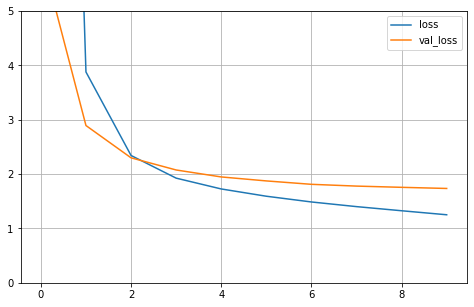

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

In [20]:
def CollaborativeModelV2(n_factors, n_users, n_anime):
    user_in = Input(shape=(1,), name="user_input")
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user_in)
    u = Flatten()(u)

    anime_in = Input(shape=(1,), name="anime_input")
    a = Embedding(n_anime, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(anime_in)
    a = Flatten()(a)

    x = Concatenate()([u, a])
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1)(x)
    x = Activation('relu')(x)
    result = Model(inputs=[user_in, anime_in], outputs=x)
    result.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    return result

In [21]:
model_2 = CollaborativeModelV2(50, filtered["user_id"].nunique(), filtered["anime_id"].nunique())
model_2.summary()
history_2 = model_2.fit({
        "user_input": X_train[:, 0],
        "anime_input": X_train[:, 1]
    },
    y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=({
        "user_input": X_test[:, 0],
        "anime_input": X_test[:, 1]
    }, y_test)
)

/Users/zengraf/.asdf/installs/python/3.9.1/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        144600      user_input[0][0]                 
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        295900      anime_input[0][0]                
____________________________________________________________________________________________

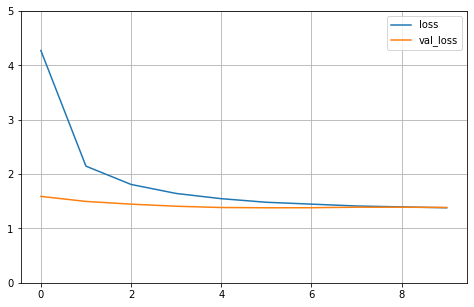

In [22]:
pd.DataFrame(history_2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 5)
plt.show()

In [23]:
class MultiLabelTransformer(BaseEstimator, TransformerMixin):
    """
    Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`
    """
    def __init__(self, column):
        self.column = column
        self.mlb = MultiLabelBinarizer(sparse_output=False)
    def fit(self, X, y=None):
        self.mlb.fit(X[self.column])
        return self
    def transform(self, X):
        return self.mlb.transform(X.loc[X[self.column].notnull(),  self.column])

class StringSplitter(BaseEstimator, TransformerMixin):
    def __init__(self, sep=","):
        self.sep = sep
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.apply(lambda c: c.fillna("None").map(lambda s: s.split(self.sep)))

In [24]:
anime_preprocessing = ColumnTransformer([
    ("genre", Pipeline([
        ("splitter", StringSplitter()),
        ("binarizer", MultiLabelTransformer("genre"))
    ]), ["genre"]),
    ("type", Pipeline([
        ("encoder", OneHotEncoder(handle_unknown='ignore'))
    ]), ["type"]),
])

In [25]:
anime_preprocessing.fit_transform(anime)

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])